# Trabalho Prático de INF723 - Visualização de Dados

- **Aluno:** Matheus dos Reis de Jesus
- **Matrícula:** ES89369

Este trabalho foi baseado no desafio proposto pela conferência BioVis 2020, e pode ser encontrado [neste link](http://biovis.net/2020/biovisChallenges_vis/#!). O desafio escolhido foi o Data Challenge, cuja proposta é:

- Para um determinado indivíduo-alvo, identifique casos semelhantes, incluindo como eles estão relacionados entre si (por exemplo, se eles co-ocorrem em uma determinada família)

- Caracterizar a distribuição de atributos clínicos para casos de suicídio em famílias com altas taxas de incidência (alto número relativo de casos)

- Caracterizar (ou seja, a relação entre os casos e seus atributos) casos de suicídio em famílias com alta incidência de um determinado atributo clínico (como depressão)

- Compare as informações clínicas para casos de suicídio com seus parentes imediatos (irmãos, pais e filhos).

Portanto, o intuito desse trabalho é responder essas perguntas utilizando visualização de dados. Para facilitar a compreensão do leitor, decidi utilizar um Jupyter Notebook, em Python, para, além de apresentar os resultados, disponibilizar também a maneira como eles foram obtidos. No bloco de código abaixo temos as bibliotecas que foram utilizadas e também o processo de leitura dos arquivos csv, que foram convertidos para DataFrames do Pandas.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re

fAttributes =  pd.read_csv("TenFamiliesAttributes.csv")
fStructure = pd.read_csv("TenFamiliesStructure.csv")

O DataFrame `fAttributes` armazena os dados sobre família, sexo, idade, ano de nascimento, ano de morte e geração. O DataFrame `fStructure` armazena os dados clínicos dos indivíduos, como doenças, vícios, índice de massa corporal e afins. Agora que já temos os dados, podemos analisar os casos de suicídio presentes no dataset. Para isso, decidi fazer um join entre os dois conjuntos, através da chave `personid`, e limitar aos registros em que houve suicídio:

In [2]:
suicide = fAttributes.merge(fStructure[fStructure["suicide"] == "Y"],on="personid",how="left")

Agora temos um novo DataFrame, `suicide`, que contém todos os registros de suicídio da base de dados fornecida, incluindo as informações clínicas e demográficas sobre os indivíduos. Uma análise interessante que podemos fazer é sobre a idade. Veja o <i>boxplot</i> abaixo:

Text(0, 0.5, 'Idade')

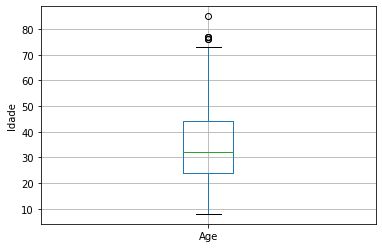

In [58]:
ageplot = suicide.boxplot("Age")
ageplot.set_ylabel("Idade")

O gráfico acima mostra a taxa de suicídio é maior na faixa de aproximadamente 23 até 45 anos. Existem alguns casos acima dos 70 anos, porém são casos isolados.

## Casos por Família

Para realizar uma melhor análise dos casos por famílias, é necessário identificar a quantidade de ocorrências em cada uma delas. No gráfico abaixo podemos visualizar essa informação. O gráfico relaciona o id de uma família com sua respectiva quantidade de casos.

Text(0, 0.5, 'Quantidade de Casos')

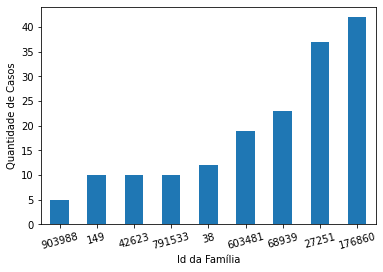

In [4]:
by_kindred = suicide.groupby("KindredID")["personid"].count().sort_values().plot.bar(rot=15)
by_kindred.set_xlabel("Id da Família")
by_kindred.set_ylabel("Quantidade de Casos")

### Análise dos Dados Clínicos

O conjunto de dados fornecidos possui informações clínicas e demográficas que podem nos auxiliar a compreender melhor os dados em questão. O conjunto de gráficos abaixo apresenta um agrupamento dos dados divididos em duas categorias: Problemas de Saúde e Método de suicídio. Os problemas de saúde representam o conjunto mais recorrente de problemas de saúde, e as formas de suicídio foram definidas através de agrupamentos, sendo eles: "Arma de fogo", "Asfixia", "Envenenamento" e "Outros" , que não se enquadram nas categorias anteriores.

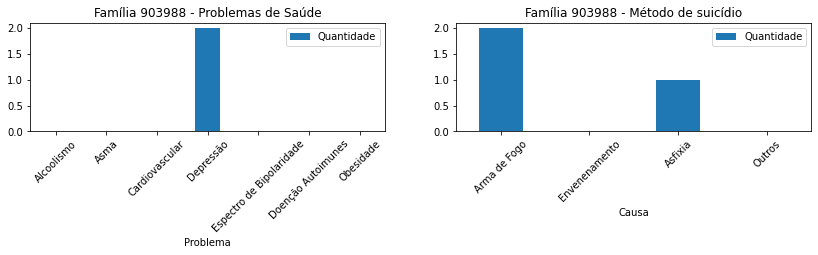

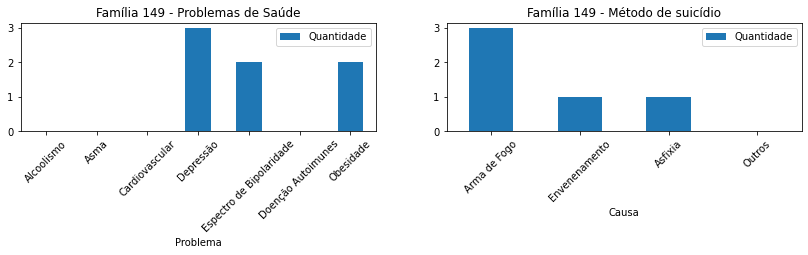

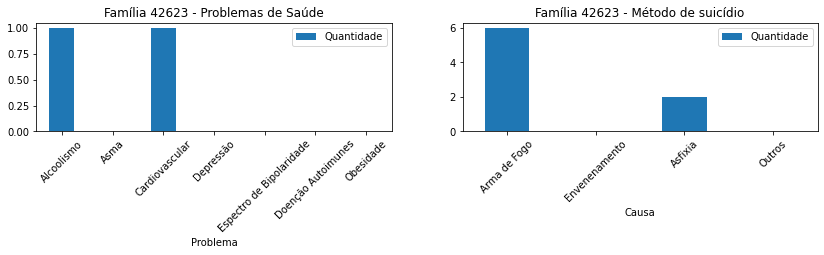

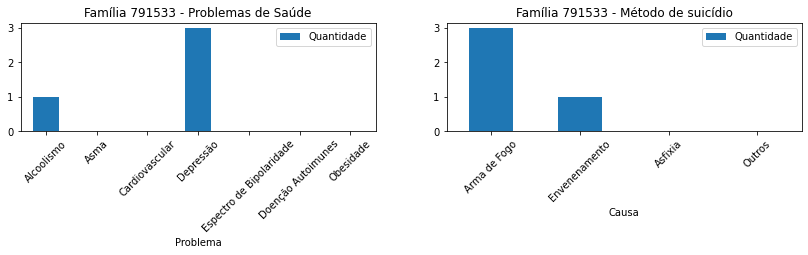

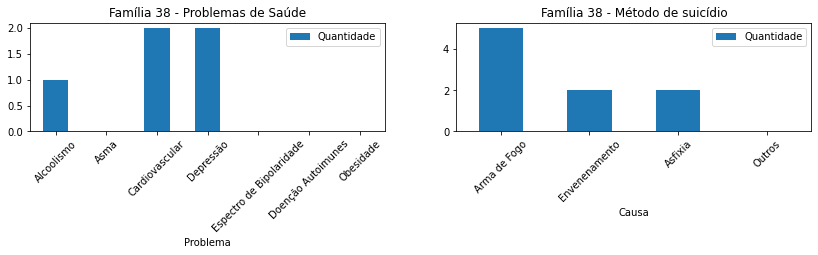

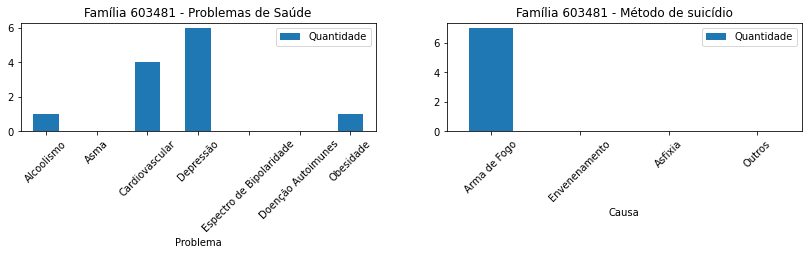

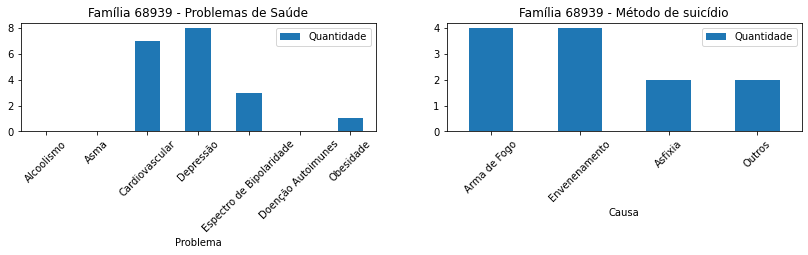

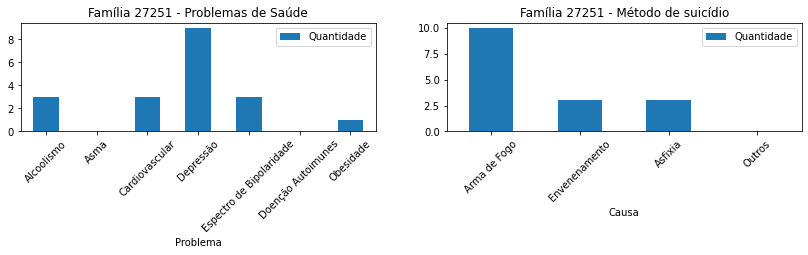

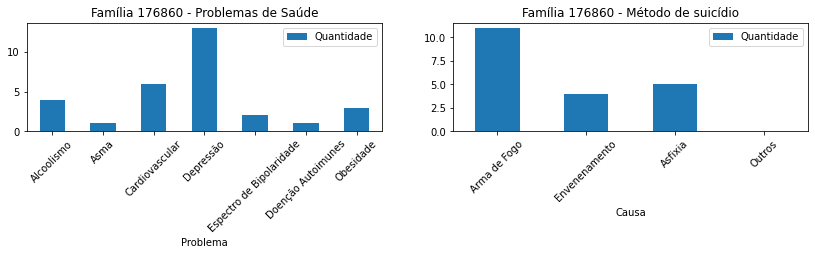

In [59]:
families = suicide.groupby("KindredID")["personid"].count().sort_values().index.values.tolist()
causes = ["Arma de Fogo","Envenenamento","Asfixia","Outros"]
health_problems = ["alcohol","asthma","cardiovascular","depression","bipolar spectrum illness","immune-autoimmune","obesity"]
translations = ["Alcoolismo", "Asma","Cardiovascular", "Depressão","Espectro de Bipolaridade","Doenção Autoimunes","Obesidade"]

for kindredId in families:
    fig, (ax1,ax2) = plt.subplots(1,2)
    family = suicide[suicide["KindredID"]==kindredId]
    
    bcd = family.groupby(["cause_death"])["cause_death"].agg("count")
    gunshot = bcd[bcd.index.str.contains(r"gun\s?shot|shotgun",regex=True,flags=re.IGNORECASE)].sum()
    poison = bcd[bcd.index.str.contains(r"intoxication|poison|toxicity",regex=True,flags=re.IGNORECASE)].sum()
    hanging = bcd[bcd.index.str.contains(r"hanging|suffocation|asphyxia|inhalation",regex=True,flags=re.IGNORECASE)].sum()
    values = [gunshot,poison,hanging,bcd.sum() - (gunshot+ poison + hanging)]
    
    by_problem = list(map(lambda problem: family[family[problem] == True].count()[0],health_problems))
    dataset = pd.DataFrame({ "Problema": translations, "Quantidade": by_problem })
    dataset.plot(kind="bar",x="Problema",y="Quantidade", ax=ax1,title=f"Família {kindredId} - Problemas de Saúde", figsize=(14,2),rot=45)
    
    dataset = pd.DataFrame({ "Causa": causes, "Quantidade": values })
    dataset.plot(kind="bar", x="Causa", y="Quantidade", ax=ax2, figsize=(14,2),title=f"Família {kindredId} - Método de suicídio",rot=45)

Se analisarmos os gráficos atentamente,  é notório que, na maioria deles, a quantidade de suicídios por arma de fogo é maior ou igual à quantidade de casos de depressão, o que pode ser um indício de que indivíduos que apresentem um quadro de depressão podem tender à cometer suicídio utilizando armas de fogo.

### Análise de Dados Demográficos

Uma das análises que pode ser feita a partir dos dados das famílias é a relação entre suicídios em um mesmo círculo familiar. Abaixo, temos a quantidade de casos relacionados através de parentes diretos em uma mesma família. O gráfico apresenta a quantidade de coincidências por ID de família.

Text(0, 0.5, 'Quantidade de casos')

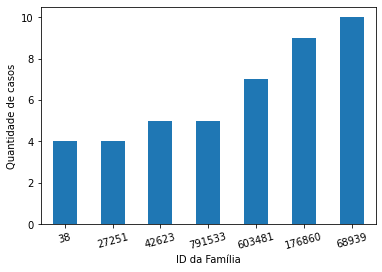

In [51]:
relationed = suicide.join(suicide.set_index("MaID"),on="MaID",rsuffix="_ma")
match = relationed[(relationed["personid"] != relationed["personid_ma"]) & ((relationed["suicide"] == "Y") & (relationed["suicide_ma"] == "Y"))]
suicide_relations = match.groupby(["KindredID"])["KindredID"].count().sort_values().plot.bar(rot=15)
suicide_relations.set_xlabel("ID da Família")
suicide_relations.set_ylabel("Quantidade de casos")